# ALZHEIMER'S DISEASE CLASSIFICATION

This notebook aims to accurately classify if a patient contains AD or if they don't have the disease. This program is unique as it was able to accurately predict (mAUC = 0.9) if someone was an AD patient or not based on common data that can anyone can get. Purposefully, not using MRI imaging as it's impractful for many due to its sheer cost. 

## The Training Data to be Preprocessed: 
The training data consist of individuals participating in the Alzheimer’s Disease Neuroimaging Initiative (ADNI), which is a longitudinal multicenter study established in 2004 with the goal of detecting AD at an early stage, tracking disease progression through biomarkers, supporting advances in AD intervention, prevention and treatment, and providing a resource for AD research. The study has grown to >1600 participants with mild cognitive impairment (MCI),ranging from Early MCI (EMCI) to Late MCI (LMCI), Alzheimer's Disease (AD) and elderly, cognitively normal (CN) control subjects that have been recruited over three phases ADNI 1, ADNI GO and ADNI 2.

628 individuals that are part of the ADNI1 study and their assessments at baseline are taken for this model. The primary phenotype is diagnostic group and MMSE. Other measures provided include age, years of education, gender, APOE4 and APOE allele 1 and allele2 genotypes, and whole genome imputed genotypes.

  ### -Descriptions  
    -directory.id: Id assigned to imaging directories. Not from LONi data
    -Subject (PTID): Participant ID
    -RID: Participant roster ID
    -Image.Data.ID: MRI ID
    -Modality: Image type
    -Visit: 1=screening scan
    -Acq.Date: MRI date
    -DX.bl: Diagnosis at baseline
    -EXAMDATE: Examination Date
    -AGE: Age at baseline
    -PTGENDER: Sex
    -PTEDUCAT: Years of Education
    -PTETHCAT: Ethnicity
    -PTRACCAT: Race
    -APOE4: APOE4 genotype
    -MMSE: MMSE score
    -imputed_genotype: Challenge specific designation, TRUE=has imputed genotypes
    -APOE Genotype: APOE allele 1 and allele 2 genotypes
    -Dx Codes for Submission: The LMCI in the ADNI data is equivalent to MCI in test. This column just converts LMCI->MCI

In [491]:
import numpy as np
import sklearn as sk
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math 

from numpy import mean
from numpy import std
from numpy import absolute
from math import sqrt
from numpy.random import randn
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RepeatedKFold

warnings.filterwarnings('ignore')
%matplotlib inline

In [492]:
data = pd.read_csv("ADNI_Training_Q3_APOE_CollectionADNI1Complete 1Yr 1.5T_July22.2014.csv") # Get the Data 
data.head(4) # Peak at the data 

,directory.id,Subject,RID,Image.Data.ID,Modality,Visit,Acq.Date,DX.bl,EXAMDATE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype,Dx Codes for Submission
0,4702245ea294ce5d4e9b8a87027dfdf4,011_S_0003,3,32237,MRI,1,9/1/05,AD,9/12/05,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4",AD
1,2e89e352af743597b2368c412e0f6de2,022_S_0004,4,64631,MRI,1,9/22/05,LMCI,11/8/05,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3",MCI
2,90419199306997753de8042f1fd55e38,011_S_0005,5,32246,MRI,1,9/2/05,CN,9/7/05,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3",CN
3,d8d175ffff1e2053e6a18c5df494ccdf,100_S_0006,6,33025,MRI,1,11/15/05,LMCI,11/29/05,80.4,Female,13,Not Hisp/Latino,White,0,25,True,"3,3",MCI


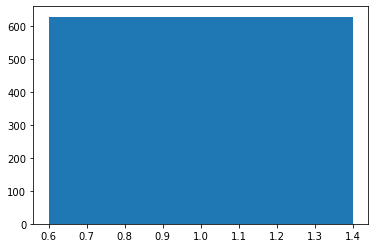

In [493]:
test = data['Visit']
plt.bar(test.value_counts().index, test.value_counts())
plt.show() 

In [494]:
data = data.drop(['directory.id', 'Subject', 'Image.Data.ID', 'RID', 'Modality', 'Visit',  'Acq.Date', 'DX.bl', 'EXAMDATE'], axis=1) # Remove Unneccesary Data

In [495]:
data

,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype,Dx Codes for Submission
0,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4",AD
1,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3",MCI
2,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3",CN
3,80.4,Female,13,Not Hisp/Latino,White,0,25,True,"3,3",MCI
4,73.9,Female,12,Not Hisp/Latino,White,1,24,True,"3,4",AD
...,...,...,...,...,...,...,...,...,...,...
623,74.4,Female,12,Not Hisp/Latino,White,1,29,True,"3,4",MCI
624,69.4,Male,19,Not Hisp/Latino,White,1,29,True,"3,4",MCI
625,75.6,Female,16,Not Hisp/Latino,White,0,28,True,"3,3",MCI
626,83.4,Male,18,Not Hisp/Latino,White,0,26,True,"3,3",MCI


In [496]:
for var in range(0, len(data)):
    if (data.at[var,"Dx Codes for Submission"] == "MCI"):
        data.at[var,"Dx Codes for Submission"] = "NOT AD"
    if (data.at[var,"Dx Codes for Submission"] == "CN"): 
        data.at[var,"Dx Codes for Submission"] = "NOT AD"
data.head(4)


,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype,Dx Codes for Submission
0,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4",AD
1,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3",NOT AD
2,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3",NOT AD
3,80.4,Female,13,Not Hisp/Latino,White,0,25,True,"3,3",NOT AD


HEAT MAP :



,AGE,PTEDUCAT,APOE4,MMSE
AGE,1.000000,-0.015779,-0.171706,-0.016813
PTEDUCAT,-0.015779,1.000000,-0.051488,0.232190
APOE4,-0.171706,-0.051488,1.000000,-0.240506
MMSE,-0.016813,0.232190,-0.240506,1.000000


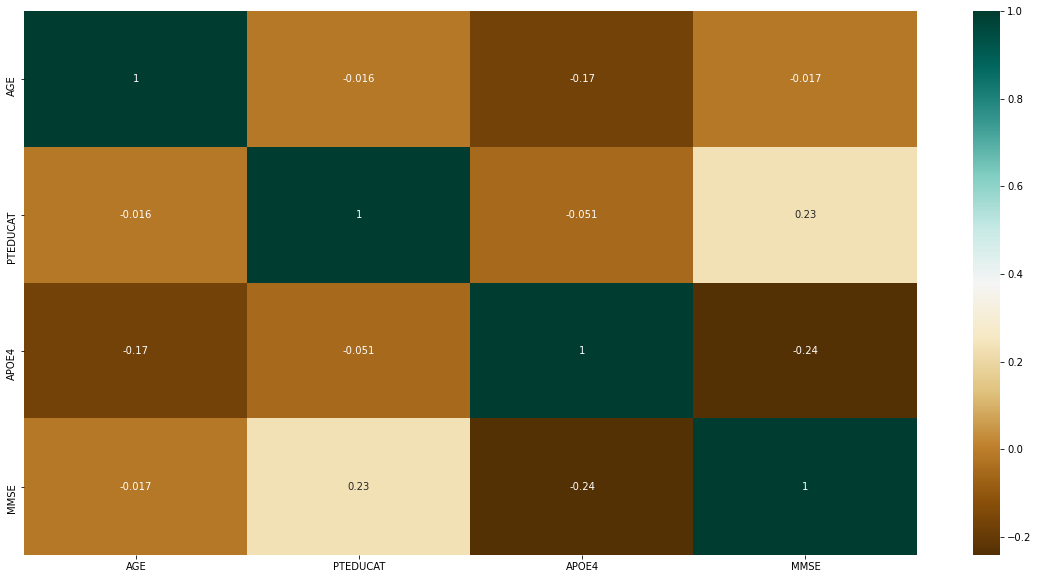

In [497]:
print('HEAT MAP :\n')

plt.figure(figsize=(20,10))
c= data.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

In [498]:
categorical_variables = ['PTGENDER', 'PTETHCAT', 'PTRACCAT', 'imputed_genotype', 'APOE Genotype', 'Dx Codes for Submission']
for var in categorical_variables:
    if (var == 'Dx Codes for Submission'):
        X = data.drop(["Dx Codes for Submission"], axis=1)
        y = data["Dx Codes for Submission"]
    data = pd.concat([data, pd.get_dummies(data[var])], axis=1)
    data = data.drop(var, axis=1)
# Implements One Hot Encoder for the purpose of replacing the Categorical Values with Numerical Values to implement regression models
data

,AGE,PTEDUCAT,APOE4,MMSE,Female,Male,Hisp/Latino,Not Hisp/Latino,Unknown,Asian,...,False,True,"2,2","2,3","2,4","3,3","3,4","4,4",AD,NOT AD
0,81.3,18,1,20,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0
1,67.5,10,0,27,0,1,1,0,0,0,...,1,0,0,0,0,1,0,0,0,1
2,73.7,16,0,29,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
3,80.4,13,0,25,1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,73.9,12,1,24,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,74.4,12,1,29,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
624,69.4,19,1,29,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
625,75.6,16,0,28,1,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
626,83.4,18,0,26,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1


In [499]:
from scipy import stats #Removing Outliers to improve the model
import numpy as np 
z = np.abs(stats.zscore(data)) 
print(z)

[[0.91743791 0.80109588 0.587593   ... 0.35702742 1.92919789 1.92919789]
 [1.14778038 1.88741827 0.87672607 ... 0.35702742 0.51835014 0.51835014]
 [0.21992868 0.12896734 0.87672607 ... 0.35702742 0.51835014 0.51835014]
 ...
 [0.06441296 0.12896734 0.87672607 ... 0.35702742 0.51835014 0.51835014]
 [1.23171025 0.80109588 0.87672607 ... 0.35702742 0.51835014 0.51835014]
 [0.83350803 1.21528974 0.87672607 ... 0.35702742 0.51835014 0.51835014]]


In [500]:
threshold = 3
print(np.where(z > 3))

(array([  1,   1,   5,   5,   7,   7,   8,   9,   9,   9,  10,  10,  11,
        11,  15,  21,  22,  23,  23,  28,  28,  28,  31,  31,  33,  33,
        34,  35,  42,  42,  42,  55,  57,  65,  66,  83,  85, 107, 108,
       117, 117, 121, 124, 125, 126, 126, 132, 132, 156, 163, 166, 166,
       169, 169, 171, 171, 181, 186, 186, 192, 210, 210, 215, 216, 225,
       238, 238, 238, 239, 244, 244, 252, 253, 253, 279, 286, 293, 295,
       301, 306, 309, 309, 315, 315, 340, 373, 389, 395, 395, 398, 400,
       408, 409, 409, 410, 410, 415, 429, 429, 431, 433, 433, 436, 436,
       436, 439, 444, 446, 447, 451, 451, 457, 457, 462, 462, 466, 469,
       469, 476, 476, 477, 477, 486, 486, 491, 491, 491, 496, 496, 498,
       498, 502, 502, 503, 503, 511, 511, 516, 516, 517, 524, 524, 527,
       530, 530, 530, 532, 532, 540, 541, 541, 541, 548, 548, 548, 550,
       554, 554, 554, 563, 565, 570, 570, 575, 591, 591, 597, 597, 608,
       608, 610, 613, 616, 616]), array([ 6,  7,  6,  7, 10, 11

In [501]:
print(z[1][6])

8.803408430829505


In [502]:
new_data = data[(z < 3).all(axis=1)]

In [503]:
X = new_data.drop(["AD", "NOT AD"], axis=1)

In [504]:
X

,AGE,PTEDUCAT,APOE4,MMSE,Female,Male,Hisp/Latino,Not Hisp/Latino,Unknown,Asian,Black,White,False,True,"2,2","2,3","2,4","3,3","3,4","4,4"
0,81.3,18,1,20,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0
2,73.7,16,0,29,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0
3,80.4,13,0,25,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
4,73.9,12,1,24,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0
6,80.8,18,1,29,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,74.4,12,1,29,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0
624,69.4,19,1,29,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0
625,75.6,16,0,28,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
626,83.4,18,0,26,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0


In [505]:
rows = []
for row in X.index: 
    rows.append(row)

rows_not_there = []

counter = 0
for r in range(0,len(data)):
    if (rows[counter] == r):
        counter = counter + 1
        continue
    else:
        rows_not_there.append(r)

In [506]:
for var in rows_not_there:
    y = y.drop([var], axis=0)
len(y)

519

HEAT MAP :



,AGE,PTEDUCAT,APOE4,MMSE,Female,Male,Hisp/Latino,Not Hisp/Latino,Unknown,Asian,...,False,True,"2,2","2,3","2,4","3,3","3,4","4,4",AD,NOT AD
AGE,1.000000,-0.015779,-0.171706,-0.016813,-0.057048,0.057048,-0.079806,0.060065,0.015522,0.024930,...,-0.069152,0.066381,-0.014123,0.001449,0.054890,0.118782,-0.015957,-0.185457,-0.026803,0.026803
PTEDUCAT,-0.015779,1.000000,-0.051488,0.232190,-0.194800,0.194800,-0.076014,0.064366,0.001174,0.090162,...,-0.035806,0.032818,0.064276,-0.022265,0.022509,0.059211,-0.047275,-0.024932,-0.151881,0.151881
APOE4,-0.171706,-0.051488,1.000000,-0.240506,-0.009748,0.009748,-0.058006,0.028190,0.040710,-0.045584,...,-0.039491,0.042602,-0.049555,-0.243577,0.085430,-0.776331,0.432988,0.732589,0.218974,-0.218974
MMSE,-0.016813,0.232190,-0.240506,1.000000,-0.021397,0.021397,-0.007560,-0.008894,0.029217,-0.026058,...,-0.015928,0.017205,0.067993,0.088222,0.004522,0.162882,-0.107324,-0.179423,-0.688725,0.688725
Female,-0.057048,-0.194800,-0.009748,-0.021397,1.000000,-1.000000,0.075852,-0.107603,0.081352,-0.010535,...,0.091011,-0.087727,-0.048137,0.076080,0.012122,-0.026164,-0.006109,-0.008630,0.071763,-0.071763
Male,0.057048,0.194800,0.009748,0.021397,-1.000000,1.000000,-0.075852,0.107603,-0.081352,0.010535,...,-0.091011,0.087727,0.048137,-0.076080,-0.012122,0.026164,0.006109,0.008630,-0.071763,0.071763
Hisp/Latino,-0.079806,-0.076014,-0.058006,-0.007560,0.075852,-0.075852,1.000000,-0.850737,-0.007870,-0.016515,...,0.128422,-0.127749,-0.006421,-0.031559,-0.016515,0.071065,-0.024240,-0.040556,-0.058881,0.058881
Not Hisp/Latino,0.060065,0.064366,0.028190,-0.008894,-0.107603,0.107603,-0.850737,1.000000,-0.518880,0.019413,...,-0.116203,0.115483,0.007547,-0.009967,0.019413,-0.028507,0.022139,0.009339,0.039502,-0.039502
Unknown,0.015522,0.001174,0.040710,0.029217,0.081352,-0.081352,-0.007870,-0.518880,1.000000,-0.010073,...,0.012212,-0.011935,-0.003916,0.070292,-0.010073,-0.061348,-0.002695,0.048194,0.020611,-0.020611
Asian,0.024930,0.090162,-0.045584,-0.026058,-0.010535,0.010535,-0.016515,0.019413,-0.010073,1.000000,...,0.247617,-0.246587,-0.008218,0.046331,-0.021138,0.028992,-0.036880,-0.016590,-0.020617,0.020617


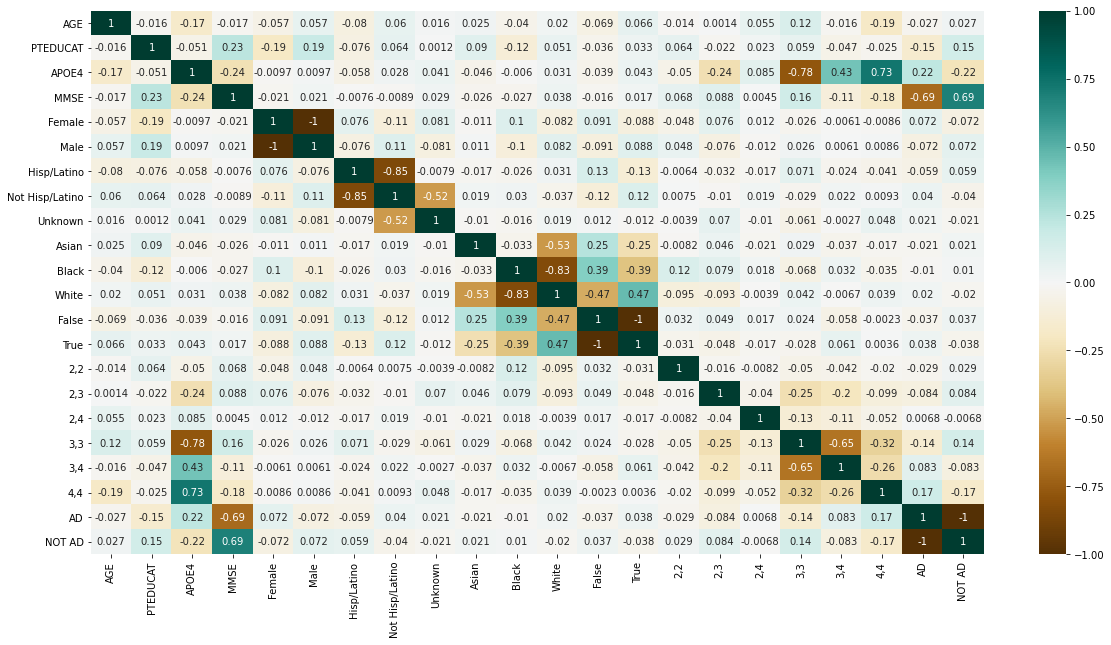

In [507]:
print('HEAT MAP :\n')

plt.figure(figsize=(20,10))
c= data.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

In [508]:
X.head(4)

,AGE,PTEDUCAT,APOE4,MMSE,Female,Male,Hisp/Latino,Not Hisp/Latino,Unknown,Asian,Black,White,False,True,"2,2","2,3","2,4","3,3","3,4","4,4"
0,81.3,18,1,20,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0
2,73.7,16,0,29,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0
3,80.4,13,0,25,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
4,73.9,12,1,24,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0


In [509]:
y.head(4)

0        AD
2    NOT AD
3    NOT AD
4        AD
Name: Dx Codes for Submission, dtype: object

#### We removed all the outliers and removed the classifiers: MCI and CN, and replaced them with the classifier "NOT AD". This will improve our model and give us the information that we need. 

# Creating the Model 

## MODEL 1: NAIVE BAYES

In [510]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import label_binarize
Binary_Y = label_binarize(y, classes=['AD', 'NOT AD'])
X_train, X_test, y_train, y_test = train_test_split(X, Binary_Y , random_state=0)

In [511]:
print("X_train shape: \n")
print(X_train.shape)
print("\nX_test shape: \n")
print(X_test.shape)
print("\ny_train shape: \n")
print(y_train.shape)
print("\ny_test shape: \n")     
print(y_test.shape) 


X_train shape: 

(389, 20)

X_test shape: 

(130, 20)

y_train shape: 

(389, 1)

y_test shape: 

(130, 1)


In [512]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [513]:
print("Classification Accuracy = " , end = " ")
counter = 0
counter2 = 0

for var in y_test:
    if (y_pred[counter2] == var):
        counter = counter + 1
    counter2 = counter2 + 1 
print(counter/len(y_pred))

Classification Accuracy =  0.9461538461538461


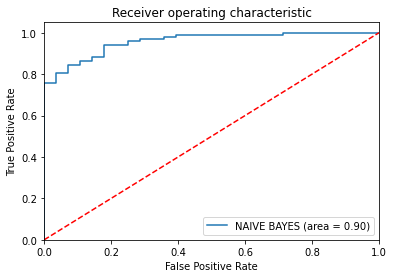

In [514]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, gnb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='NAIVE BAYES (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### MODEL 2: Logistic Regression 

In [515]:
from sklearn.linear_model import LogisticRegression

In [516]:
X_train, X_test, y_train, y_test = train_test_split(X, Binary_Y, test_size=0.3, random_state=0)

In [517]:
print("X_train shape: \n")
print(X_train.shape)
print("\nX_test shape: \n")
print(X_test.shape)
print("\ny_train shape: \n")
print(y_train.shape)
print("\ny_test shape: \n")     
print(y_test.shape)

X_train shape: 

(363, 20)

X_test shape: 

(156, 20)

y_train shape: 

(363, 1)

y_test shape: 

(156, 1)


In [518]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [519]:
y_pred = logreg.predict(X_test)
print("Classification Accuracy = " , end = " ")
counter = 0
counter2 = 0

for var in y_test:
    if (y_pred[counter2] == var):
        counter = counter + 1
    counter2 = counter2 + 1
print(counter/len(y_pred))

Classification Accuracy =  0.8910256410256411


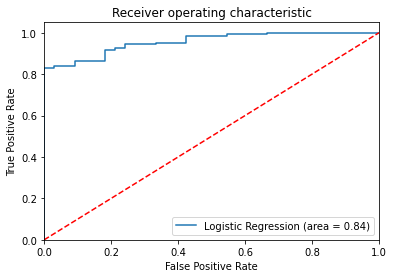

In [520]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Model 3 : K-Nearest Neighbors


In [521]:
from sklearn.neighbors import KNeighborsClassifier

In [522]:
X_train, X_test, y_train, y_test = train_test_split(X, Binary_Y, test_size=0.3, random_state=101)


In [523]:
print("X_train shape: \n")
print(X_train.shape)
print("\nX_test shape: \n")
print(X_test.shape)
print("\ny_train shape: \n")
print(y_train.shape)
print("\ny_test shape: \n")     
print(y_test.shape)

X_train shape: 

(363, 20)

X_test shape: 

(156, 20)

y_train shape: 

(363, 1)

y_test shape: 

(156, 1)


In [524]:
knn = KNeighborsClassifier(n_neighbors=7)

In [525]:
y_pred = knn.fit(X_train, y_train).predict(X_test)

In [526]:
print("Classification Accuracy = " , end = " ")
counter = 0
counter2 = 0

for var in y_test:
    if (y_pred[counter2] == var):
        counter = counter + 1
    counter2 = counter2 + 1
print((counter)/len(y_pred))

Classification Accuracy =  0.8525641025641025


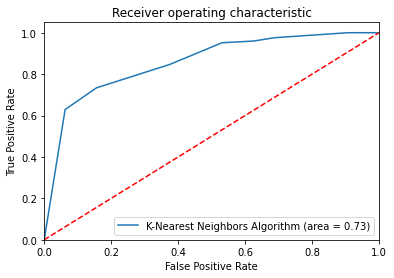

In [527]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='K-Nearest Neighbors Algorithm (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Model 4: Decision Trees

In [528]:
from sklearn.tree import DecisionTreeClassifier 

In [529]:
model_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth = 3, min_samples_leaf = 5) 

In [530]:
model_entropy.fit(X_train, y_train) 

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5,
                       random_state=100)

In [531]:
y_pred = model_entropy.predict(X_test) 

In [532]:
print("Classification Accuracy = " , end = " ")
counter = 0
counter2 = 0

for var in y_test:
    if (y_pred[counter2] == var):
        counter = counter + 1
    counter2 = counter2 + 1
print((counter)/len(y_pred))

Classification Accuracy =  0.8846153846153846


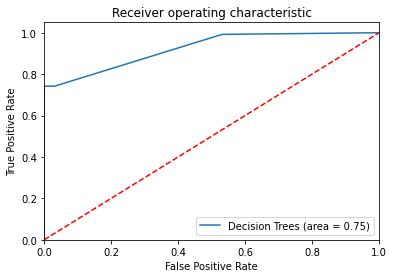

In [533]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, model_entropy.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model_entropy.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Trees (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Model 5 : Support Vector Machines

#### Try all four Kernels:

In [534]:
from sklearn import svm

In [535]:
model = svm.SVC(kernel = 'linear', gamma = 'auto', C = 1.5)

In [536]:
model.fit(X_train, y_train)

SVC(C=1.5, gamma='auto', kernel='linear')

In [537]:
y_pred = model.predict(X_test)

In [538]:
print("Classification Accuracy = " , end = " ")
counter = 0
counter2 = 0

for var in y_test:
    if (y_pred[counter2] == var):
        counter = counter + 1
    counter2 = counter2 + 1
print(counter/len(y_pred))

Classification Accuracy =  0.8589743589743589


In [539]:
model = svm.SVC(kernel = 'sigmoid', gamma = 'auto', C = 1.5)

In [540]:
model.fit(X_train, y_train)

SVC(C=1.5, gamma='auto', kernel='sigmoid')

In [541]:
y_pred = model.predict(X_test)

In [542]:
print("Classification Accuracy = " , end = " ")
counter = 0
counter2 = 0

for var in y_test:
    if (y_pred[counter2] == var):
        counter = counter + 1
    counter2 = counter2 + 1
print(counter/len(y_pred))

Classification Accuracy =  0.7948717948717948


In [543]:
model = svm.SVC(kernel = 'rbf', gamma = 'auto', C = 1.5)

In [544]:
model.fit(X_train, y_train)

SVC(C=1.5, gamma='auto')

In [545]:
y_pred = model.predict(X_test)

In [546]:
print("Classification Accuracy = " , end = " ")
counter = 0
counter2 = 0

for var in y_test:
    if (y_pred[counter2] == var):
        counter = counter + 1
    counter2 = counter2 + 1
print(counter/len(y_pred))

Classification Accuracy =  0.8333333333333334


In [547]:
model = svm.SVC(kernel = 'poly', gamma = 'auto', C = 1.5)

In [548]:
model.fit(X_train, y_train)

SVC(C=1.5, gamma='auto', kernel='poly')

In [549]:
y_pred = model.predict(X_test)

In [550]:
print("Classification Accuracy = " , end = " ")
counter = 0
counter2 = 0

for var in y_test:
    if (y_pred[counter2] == var):
        counter = counter + 1
    counter2 = counter2 + 1
print(counter/len(y_pred))

Classification Accuracy =  0.8653846153846154


Linear Kernel had the highest accuracy, so we will investigate it rather than the other 3

In [551]:
model = svm.SVC(kernel = 'linear', gamma = 'auto', C = 1.5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

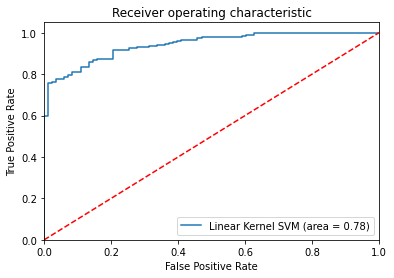

In [552]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Linear Kernel SVM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Conclusion

#### The best model for classifying a patient was easily the Naive Bayes Algorithm. I believe that this was the most succesful model out of the 5 that I tested as Naive Bayes is predicated on the features having independence, and the variables in question have very little correlation. The model was able to accurately predict if a person has Alzheimer's disease or not with a classification accuracy of  0.9461538461538461. Additionaly, with a AUC score of 0.9, which is outstanding, as it measures the true positives and negatives. 